In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from pandas.plotting import lag_plot

c:\Users\Admin\anaconda3\envs\quant\Lib\site-packages\yfinance\scrapers\history.py:204: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed

                            OLS Regression Results                            
Dep. Variable:      1 Period % Change   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.583
Date:                Thu, 19 Feb 2026   Prob (F-statistic):              0.207
Time:                        13:41:31   Log-Likelihood:                 1119.2
No. Observations:                 350   AIC:                            -2232.
Df Residuals:                     347   BIC:                            -2221.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.002     -0.724      0.4

Price,Close,High,Low,Open,Volume,Close + 1,1 Period % Change,High_2prev,Bull_FVG,Bull_FVG_Val,Low_2prev,Bear_FVG,Bear_FVG_Val,Both_FVG,Predictions,residuals
Date,,,,,,,,,,,,,,,,
2022-02-28,413.016815,414.501916,407.407520,408.665580,145615000,406.726440,-0.015230,405.572442,1,0.004443,388.432386,0,0.000000,0.004443,0.002202,-0.017432
2022-03-07,396.746979,408.920957,396.680757,408.211518,137896600,393.738953,-0.007582,417.254443,0,-0.000000,410.339775,1,-0.003576,-0.003576,0.001232,-0.008814
2022-03-08,393.738953,404.106221,392.670059,396.926696,164772700,404.295380,0.026811,409.933121,0,-0.000000,404.740032,1,-0.001610,-0.001610,0.001968,0.024842
2022-03-16,412.061462,412.118215,401.826606,406.641362,144954800,417.216644,0.012511,401.589982,1,0.000574,393.303749,0,0.000000,0.000574,0.001795,0.010716
2022-03-17,417.216644,417.216644,409.762795,410.141157,102676900,421.786346,0.010953,403.756217,1,0.014397,395.791592,0,0.000000,0.014397,0.002358,0.008595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-22,688.979980,691.130005,686.919983,689.849976,77112200,689.229980,0.000363,684.770020,1,0.003121,676.570007,0,0.000000,0.003121,0.000700,-0.000337
2026-01-27,695.489990,696.530029,693.570007,694.179993,55506100,695.419983,-0.000101,690.960022,1,0.003753,687.159973,0,0.000000,0.003753,0.000333,-0.000434
2026-02-05,677.619995,683.690002,675.789978,680.940002,113610800,690.619995,0.019185,696.960022,0,-0.000000,684.030029,1,-0.000502,-0.000502,0.001060,0.018125


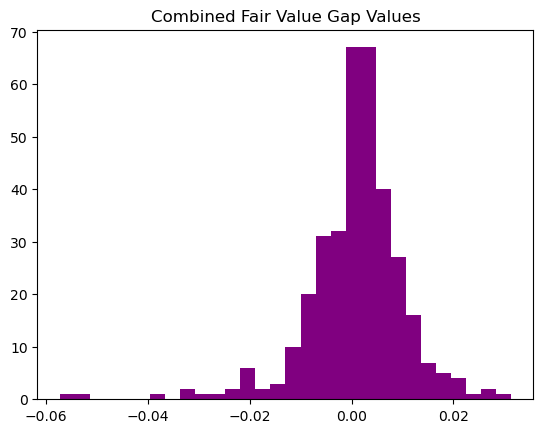

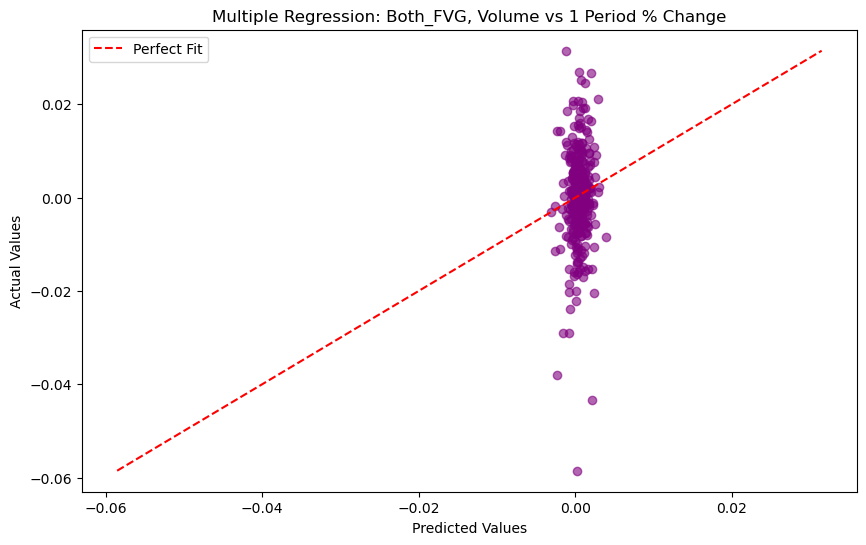

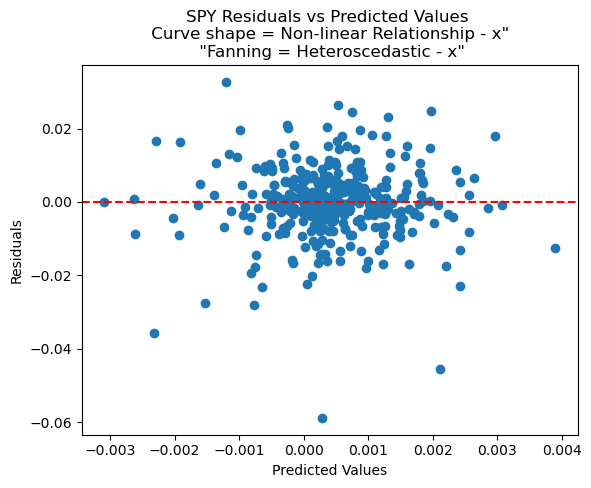

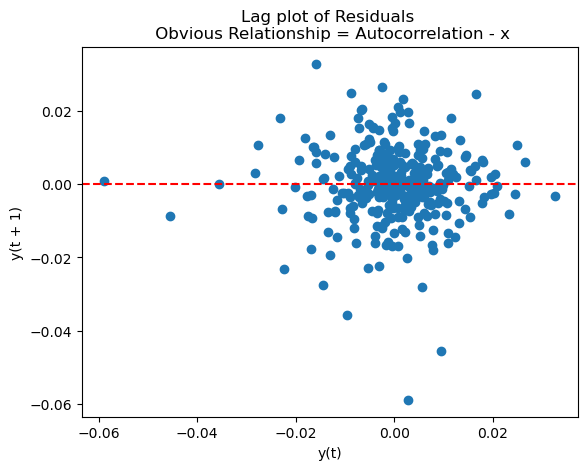

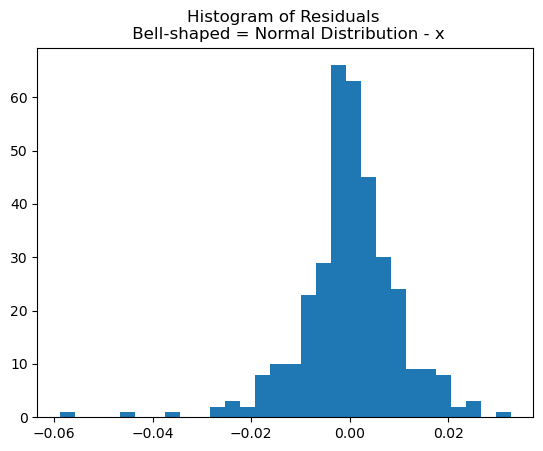

In [11]:
ticker = 'SPY'
LOOKBACK = -1000
SHIFT = 1
STRATEGY=['Both_FVG', 'Volume']
target = f'{SHIFT} Period % Change'
interval = '1d'

if interval == '1h':
    period = "730d"
else:
    period = "max"

def get_data(interval=interval):
    df = yf.download(ticker, period = period, auto_adjust=True, interval=interval)
    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)

    return df.iloc[LOOKBACK:,:]

def add_target(df, shift=SHIFT):

    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    #what is the change in  close price SHIFT days from now?
    df[f'{SHIFT} Period % Change'] = ((df[f'Close + {shift}'] - df['Close']) / df['Close'])

    #df[f'{SHIFT} Period % Change'] = -1 * df[f'{SHIFT} Period % Change']

    return df

def bull_fvg(df):

    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    '''fvg_subset = df[df['Bull_FVG_Val'] > 0]

    plt.figure()
    plt.hist(fvg_subset['Bull_FVG_Val'], bins=10)
    plt.title("Bullish Fair Value Gap Values")'''

    return df

def bear_fvg(df):
    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    '''fvg_subset = df[df['Bear_FVG_Val'] < 0]

    plt.figure()
    plt.hist(fvg_subset['Bear_FVG_Val'], bins=10, color='red')
    plt.title("Bearish FairValue Gap Values")'''

    return df

def prepare_dataframe_for_regression(df):
    df = df[(df['Bull_FVG'] == 1) | (df['Bear_FVG'] == 1)].copy()
    df['Both_FVG'] = df['Bull_FVG_Val'] + df['Bear_FVG_Val']

    # Only look at gaps bigger than 1%
    #df = df[abs(df['Both_FVG']) > 0.01]

    plt.figure()
    plt.hist(df['Both_FVG'], bins=30, color='purple')
    plt.title("Combined Fair Value Gap Values")
    return df

def generate_regression_output(df, features=STRATEGY, target=target):
    # Ensure we only use rows where all chosen features and the target exist
    # Nathan's specific syntax: features + [target] creates a single list for indexing
    subset = df[features + [target]].dropna()
    
    # Define X (independent variables) and y (dependent variable)
    x = subset[features]
    y = subset[target]
    
    # ADD CONSTANT: Essential for a valid regression intercept
    x_with_const = sm.add_constant(x)
    
    # Fit the Multiple Linear Regression Model
    model = sm.OLS(y, x_with_const).fit()
    
    # Extract coefficients and intercept for the summary
    intercept = model.params['const']
    coefficients = model.params.drop('const')
    
    # Print the full model summary (Nathan emphasizes the F-statistic here)
    print(model.summary())
    
    # Create the Predicted vs Actual Plot
    y_pred = model.predict(x_with_const)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, y, alpha=0.6, color='purple')
    
    # Add the "Perfect Fit" 45-degree line
    line_range = [y.min(), y.max()]
    plt.plot(line_range, line_range, color='red', linestyle='--', label='Perfect Fit')
    
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(f'Multiple Regression: {", ".join(features)} vs {target}')
    plt.legend()
    
    return df, coefficients, intercept

def validate_regression_output(df, coef, intercept, features=f'STRATEGY', target=f'{SHIFT} Period % Change'):
    # y = mx + c
    #info neccessary
    #test_linearity_homoscedasticity
    df['Predictions'] = (df[features] @ coef )+ intercept
    df['residuals'] = df[target] - df['Predictions']

    #plot relationship
    plt.figure()
    plt.scatter(df['Predictions'], df['residuals'])
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{ticker} Residuals vs Predicted Values \n Curve shape = Non-linear Relationship - x" \n "Fanning = Heteroscedastic - x"')

    #test_independence
    plt.figure()
    lag_plot(df['residuals'].dropna())
    plt.title('Lag plot of Residuals \n Obvious Relationship = Autocorrelation - x')
    plt.axhline(0, color='red', linestyle='--')

    #test_normality
    plt.figure()
    plt.hist(df['residuals'].dropna(), bins=30)
    plt.title('Histogram of Residuals \n Bell-shaped = Normal Distribution - x')
    return df


def main():
    df = get_data(interval=interval)
    df = add_target(df, shift=SHIFT)
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = prepare_dataframe_for_regression(df)
    df, coef, intercept = generate_regression_output(df, features=STRATEGY, target=target)
    df = validate_regression_output(df, coef=coef, intercept=intercept, features=STRATEGY, target=target)
        

    return df

df = main()
df